# Counterfactuals - what are they?

Exploring "what-if" scenarios is an important way to inspect a machine learning (ML) model. The DiCE library helps you to understand an ML model by generating "what-if" data points that lead to the desired model output. Formally, such "what-if" data points are known as counterfactuals.


**Given that the model's output for input $x$ is $y$, what would be the output if input $x$ is changed to $x'$?**

The answer to the above question can be obtained by simply inputting $x'$ to the ML model. However, in many cases, we are interested in the reverse question: what changes to $x$ would lead to a desired change in model's output? 

Here we are working with the exact same data from the other notebook but we have made some changes to get a better understanding of the what-ifs scenarios

In [26]:
#all the necessary imports

#sklearn is the library that has the main model we use
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

#pandas is used for processing the data
import pandas as pd

#these are the imports for displaying the decision tree
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import tree
from pydotplus import graph_from_dot_data

# DiCE imports for generating the counterfactuals
import dice_ml
from dice_ml.utils import helpers

In [27]:
#read in the data
df = pd.read_csv("data/income-ceml.csv")
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [28]:
#quick summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1000 non-null   int64 
 1   workclass       1000 non-null   object
 2   education       1000 non-null   object
 3   marital_status  1000 non-null   object
 4   occupation      1000 non-null   object
 5   hours_per_week  1000 non-null   int64 
 6   income          1000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


In [29]:
#perform a test-train split
target = df["income"]
train_dataset, test_dataset, y_train, y_test = train_test_split(df,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

In [30]:
#step 1 for generating counterfactuals
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

### Note about dealing with categoricals


Instead of creating a whole new column for each category, we just handled categories a little differently. We are still using [One Hot Encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) but just using a different way to create the columns directly when running the model instead of doing so beforehand. This is done just to make generating the counterfactuals much easier as we will see below

In [31]:
#Numerical features from our data
numerical = ["age", "hours_per_week"]

#Everything that isn't numerical is a category
categorical = x_train.columns.difference(numerical)

#Doing One Hot Encoding as mentioned above
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', DecisionTreeClassifier())])

#Final model
model = clf.fit(x_train, y_train)

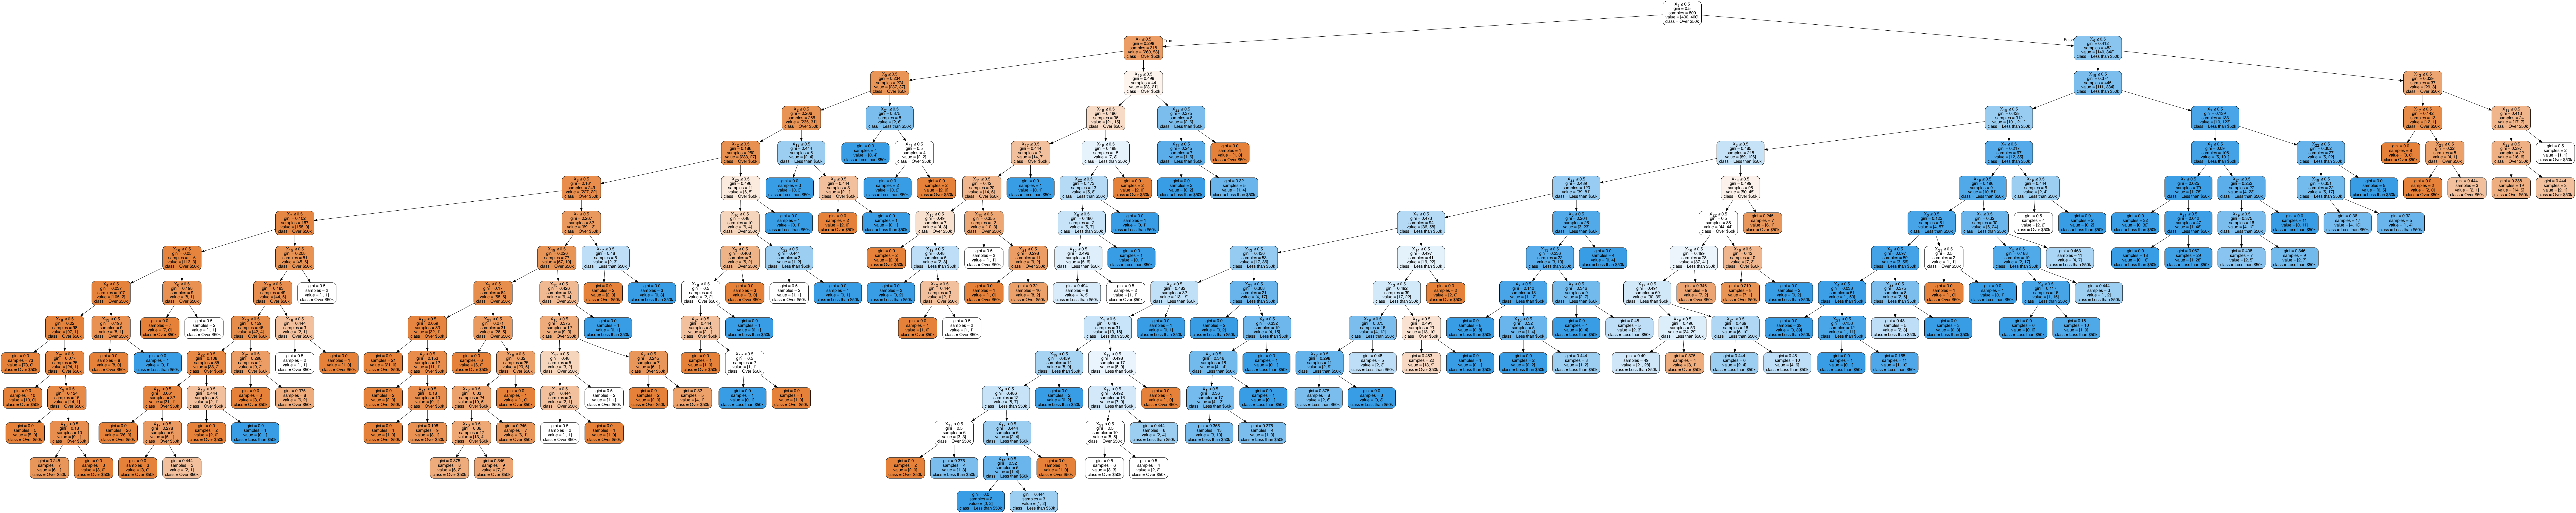

In [32]:
#Visualize the tree to quickly check it
# Create DOT data
dot_data = export_graphviz(clf.named_steps.classifier, out_file=None,   
                           class_names=['Over $50k', 'Less than $50k'], 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

### Setting up the DiCE library

The library needs a Machine learning model and it needs to know how the model was built. Along with the data which we initialized in the previous step, the model is used to build the explainer which will generate the what-if scenario values for us

In [33]:
#Final steps for generating counterfactuals
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

### Generating the counterfactuals

The next code snippet shows how to generate and visualize counterfactuals. The first argument of the generate_counterfactuals method is the data on which counterfactuals need to be generated. 

So we will use a sample whose outcome is 0 (low-income) as per the ML model we built previously. Given the sample data, we can now generate counterfactual explanations to show different inputs from the original input where the ML model outputs class 1 (high-income). 

In [34]:
#Generate counterfactuals for a point
e1 = exp.generate_counterfactuals(x_test[0:1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,18,Government,HS-grad,Single,Service,60,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,74.0,-,Prof-school,-,-,-,1
1,-,-,-,Married,-,14.0,1


In [22]:
# Changing only age and education
e2 = exp.generate_counterfactuals(x_test[0:1],
                                  total_CFs=2,
                                  desired_class="opposite",
                                  features_to_vary=["age", "education"]
                                  )
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 16.18it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,18,Government,HS-grad,Single,Service,60,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,29.0,-,Bachelors,-,-,-,1
1,-,-,Prof-school,-,-,-,1


In [41]:
# Restricting age to be between [20,30] and Education to be either {'Doctorate', 'Prof-school'}.
e3 = exp.generate_counterfactuals(x_test[0:21],
                                  total_CFs=2,
                                  desired_class="opposite",
                                  permitted_range={'age': [20, 30], 'education': ['Doctorate', 'Prof-school']})
e3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 21/21 [00:01<00:00, 19.46it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,18,Government,HS-grad,Single,Service,60,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,Prof-school,-,-,23.0,1
1,-,-,-,Divorced,-,46.0,-


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,42,Private,HS-grad,Married,Service,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Self-Employed,-,-,-,25.0,0
1,28.0,Self-Employed,-,-,-,-,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,21,Private,Some-college,Single,Service,25,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,Separated,-,85.0,-
1,-,-,-,Separated,-,-,-


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,32,Self-Employed,Some-college,Married,White-Collar,50,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Other/Unknown,-,-,Professional,-,0
1,-,-,-,Divorced,-,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,31,Government,HS-grad,Married,Service,41,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,Single,-,15.0,0
1,-,Self-Employed,-,-,-,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,26,Self-Employed,Prof-school,Single,Professional,20,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,22.0,Private,-,-,-,-,0
1,-,Private,-,-,-,-,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,47,Government,HS-grad,Married,Blue-Collar,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,Divorced,-,72.0,-
1,-,Other/Unknown,-,-,-,30.0,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,51,Private,HS-grad,Married,Service,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,20.0,-,-,-,Other/Unknown,-,0
1,30.0,-,-,-,Other/Unknown,-,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,29,Private,Bachelors,Single,Professional,60,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,Doctorate,-,-,56.0,1
1,-,-,Doctorate,-,-,23.0,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,60,Other/Unknown,HS-grad,Married,Other/Unknown,70,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Government,-,Divorced,-,-,-
1,-,-,Prof-school,-,White-Collar,-,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,53,Government,Some-college,Widowed,White-Collar,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,-,Sales,64.0,0
1,28.0,-,-,Single,-,-,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,48,Private,HS-grad,Single,White-Collar,50,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,Doctorate,-,-,63.0,1
1,-,Self-Employed,-,Married,-,-,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,52,Self-Employed,Bachelors,Married,Sales,50,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Private,-,-,-,88.0,0
1,-,-,-,Divorced,-,43.0,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,39,Private,Some-college,Married,White-Collar,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,Widowed,Service,-,0
1,-,-,Prof-school,Single,-,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,59,Self-Employed,Bachelors,Married,White-Collar,50,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Private,-,-,Sales,-,0
1,-,Government,-,Single,-,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,51,Private,Bachelors,Divorced,White-Collar,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Government,-,Separated,-,-,0
1,-,-,-,Single,Other/Unknown,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,45,Private,Masters,Married,Professional,50,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,Government,-,Single,-,-,0
1,-,Other/Unknown,-,Single,-,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,42,Private,Bachelors,Married,Service,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,-,Sales,20.0,0
1,-,-,-,-,Sales,53.0,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,37,Private,Assoc,Married,Blue-Collar,40,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,30.0,-,-,Separated,-,-,0
1,-,-,-,Divorced,-,6.0,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,38,Private,Some-college,Married,Blue-Collar,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,Doctorate,-,-,13.0,1
1,-,-,Prof-school,-,-,97.0,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,19,Private,HS-grad,Single,Service,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,hours_per_week,income
0,-,-,-,Married,White-Collar,-,1
1,29.0,-,-,Married,-,-,1


### Feature importances using DiCE

Generally, feature importance provides an indication of how useful or influential a feature was in determining the class of the outcome. DiCE can provide us with these feature importance scores which can be very helpful in understanding the data and getting more insights. We can generate feature importances for either a single sample or for our entire data

In [24]:
query_instance = x_test[0:1]
imp = exp.local_feature_importance(query_instance, total_CFs=10)
print(imp.local_importance)

100%|██████████| 1/1 [00:00<00:00,  9.99it/s]

[{'marital_status': 0.8, 'age': 0.4, 'education': 0.3, 'hours_per_week': 0.2, 'workclass': 0.1, 'occupation': 0.1}]


In [25]:
query_instances = x_test[0:20]
imp = exp.global_feature_importance(query_instances)
print(imp.summary_importance)

100%|██████████| 20/20 [00:01<00:00, 11.78it/s]

{'marital_status': 0.455, 'education': 0.405, 'hours_per_week': 0.315, 'age': 0.295, 'occupation': 0.265, 'workclass': 0.175}
